<div style='text-align: right; font-family:TimesNewRoman'>
    January 2026
</br>
    Enrico Minguzzi
</br>
    Manuel Barbieri
</div>

<h1 style='font-family:TimesNewRoman'>Product Classification with CNNs</h1> 

<div style='text-align: justify; font-family:TimesNewRoman'>
This project presents the development and evaluation of convolutional neural networks (CNNs) for the classification of smartphone pictures of grocery store products. The notebook is structures as a combination of exlanatory text and executable code, documenting both the methodological choices and the experimental results.</br></br>The work is divided into three main sections:    
    <ul style='list-style: none;'>
        <li>
            <h3>1. Design and implementation of a CNN from scratch</h3>
            A custom convolutional network is built using basic Keras layers. Starting from a simple baseline architecture, the model is progressively refined through actions on the network layout, the hyperparameters and the dataset. Said choices are motivated before they're implemented and their impact is discussed after the results have been shown. This step is to be considered completed once a validation accuracy of at least 60% is achieved.
        </li>
        <li>
            <h3>2. Fine-tuning of a pre-trained network</h3>
            A deep ResNet-based architecture pre-trained on a large-scale dataset and provided by Keras is adapted to the target task through trasnfer learning. By leveraging pre-trained features and adjusting the training strategy, the goal is to significantly improve performance, reaching a validation accuracy of at least 90%.
        </li>
        <li>
            <h3>3. Final evaluation and comaprison</h3>
            In the last section, the best-performing models of the two previous steps are evaluated on the test dataset. Their results are compared side by side, highlighting differences in accuracy and generalisation capabilities.
        </li>
    </ul>
</div>

<h2 style='font-family:TimesNewRoman'>Dataset</h2> 

<div style='text-align: justify; font-family:TimesNewRoman'>
The dataset in this project is sourced from a publicly available <a href="https://github.com/marcusklasson/GroceryStoreDataset.git">GitHub repository</a> and consists of natural pictures (i.e. RGB) of grocery store products captured using smartphone cameras in real-world environments. It is already split into training, validation and test datasets.</br></br>The dataset contains approximately 5125 pictures belonging to a wade range of product categories, including fruits, vegetables and packaged items such as milk and juice. Each picture is annoted using both a fine-grained and a coarse-grained labelling scheme, comprising 81 and 43 classes respectively. For example, a product may be labeled with a coarse-grained category such as `milk`, and a corresponding fine-grained label such as `Arla-Lactose-Free-Milk`.</br></br>In this project, only the coarse-grained labels are considered. As a result, the classification task focuses on distinguishing between general product categories rather than between specific brands or product variants.</br></br>In this first block of code, the necessary dependencies are imported and the preliminar setting is done:
</div>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import pandas as pd
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
seed = 42
keras.utils.set_random_seed(seed)
np.random.seed(seed)

<div style='text-align: justify; font-family:TimesNewRoman'>
The dataset is then loaded from the local directory in which it has been downloaded. In order to exactly replicate the execution environment used in this notebook, the `GroceryStoreDataset` folder should be placed at the same directory level as the folder containing this notebook, so that it can be accessed from this file through the following relative path: `..\GroceryStoreDataset`.</br></br>The dataset directory contains three text files (`train.txt`, `validation.txt` and `test.txt`), which devine the corresponding dataset splits. Each file lists the relative apths to the pictures belonging to that dataset, together with their associated class labels. The datasets are constructed by iterating over these files, parsing each line and extracting the relevant information needed to load the pictures and assign the correct labels.</br></br>Although Keras provides built-in utilities for creating image datasets directly from directory structure, this approach is not particularly convenient in this case. Due to the organisation of the dataset, using such utilities would require creating multiple subset of the dataset indipendently (e.g. `fruit_test`, `packages_test`, etc.) and then manually merging them into unified training, validation and test datasets. This processo would also introduce additional complexity in terms of label handling, as class indices would be defined locally within each subset. Consequently, careful label remapping would be necessacy to ensure consistency. Without it, class ID 0 in `fruit-train` would correspond to class ID 0 in `vegetables_train` and to class ID 0 in `packages-train`, and so on for every class ID and every dataset.</br></br>Given the dataset contains picture of different spatial dimension, they're resized to 256x256 during loading.
</div>

In [3]:
def load_data(url_directory, url_file, resizeX=256, resizeY=256):
    X = []
    y = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, (resizeX, resizeY))
            X.append(img_resized)
            y.append(int(line_split[2].strip()))

    return np.stack(X, axis=0), np.array(y)

In [4]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

X_train, y_train = load_data(url_directory, "train.txt")
X_val, y_val = load_data(url_directory, "val.txt")
X_test, y_test = load_data(url_directory, "test.txt")

<div style='text-align: justify; font-family:TimesNewRoman'>
Lastly, the provided `.csv` file is used to import the complete list of product classes names, together with their corresponding numerical identifiers. All references to a product's ID class in the following sections of the notebook adhere to this mapping.
</div>

In [5]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in df_coarse}
n_classes_coarse = len(labels_coarse)
labels_coarse

{0: 'Apple',
 1: 'Avocado',
 2: 'Banana',
 3: 'Kiwi',
 4: 'Lemon',
 5: 'Lime',
 6: 'Mango',
 7: 'Melon',
 8: 'Nectarine',
 9: 'Orange',
 10: 'Papaya',
 11: 'Passion-Fruit',
 12: 'Peach',
 13: 'Pear',
 14: 'Pineapple',
 15: 'Plum',
 16: 'Pomegranate',
 17: 'Red-Grapefruit',
 18: 'Satsumas',
 19: 'Juice',
 20: 'Milk',
 21: 'Oatghurt',
 22: 'Oat-Milk',
 23: 'Sour-Cream',
 24: 'Sour-Milk',
 25: 'Soyghurt',
 26: 'Soy-Milk',
 27: 'Yoghurt',
 28: 'Asparagus',
 29: 'Aubergine',
 30: 'Cabbage',
 31: 'Carrots',
 32: 'Cucumber',
 33: 'Garlic',
 34: 'Ginger',
 35: 'Leek',
 36: 'Mushroom',
 37: 'Onion',
 38: 'Pepper',
 39: 'Potato',
 40: 'Red-Beet',
 41: 'Tomato',
 42: 'Zucchini'}

In [6]:
print(f"The shape of the training set is {X_train.shape}")
print(f"The shape of the validation set is {X_val.shape}")
print(f"The shape of the testing set is {X_test.shape}")

The shape of the training set is (2640, 256, 256, 3)
The shape of the validation set is (296, 256, 256, 3)
The shape of the testing set is (2485, 256, 256, 3)


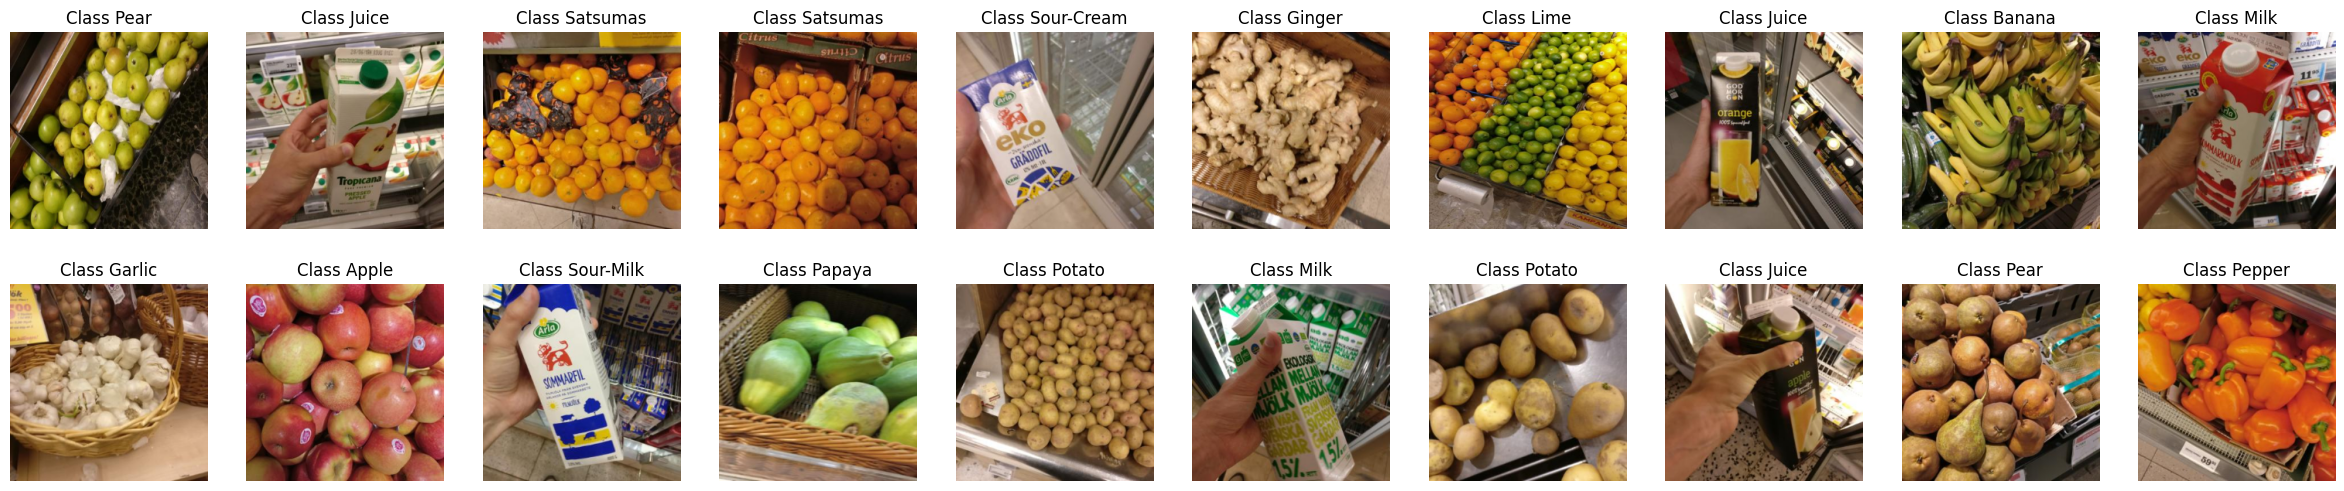

In [7]:
fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()
for i in range(20):
    rand_idx = np.random.randint(0, X_train.shape[0])
    ax[i].set_axis_off()
    ax[i].set_title(f"Class {labels_coarse[y_train[rand_idx]]}")
    ax[i].imshow(cv2.cvtColor(X_train[rand_idx], cv2.COLOR_BGR2RGB))

<h1 style='font-family:TimesNewRoman'>1. Building a network from scratch</h1>

<div style='text-align: justify; font-family:TimesNewRoman'>
After loading the dataset, an initial inspection shows that all pictures have a spatial resolution of 256x256 pixels and consist of three color channels (RGB). In this first phase of the project, only the training and validation splits are used, for a total of approximately 3.000 pictures. The test set is intentionally left untouched and reserved for the final evaluation.</br></br>The first iteration of the CNN is deliverately kept as simple as possible. No preprocessing steps such as data normalisation or data augmentation are applied at this stage. This baseline configuration allows for a clearer assessment of the model's inherent capacity and provides a starting point.</br>
</div>

<h2 style='font-family:TimesNewRoman'>1.1 First Iteration — Basic</h2> 

<div style='text-align: justify; font-family:TimesNewRoman'>
The baseline model consists of minimal convolutional architecture inspired by the network introduced during the laboratory session. It is composed of three main learnable layers: two convolutional layers with 3x3 kenrels, followed by a fully connected layer responsible for the final classification.</br></br>The convolutional layers are onfigured with a stride of 1 and appropriate padding to preserve the spatial resolution of the feature maps. Spatial downsampling is instead achieved through max-pooling operations applied after each convolutional layer. As the spatial dimensions of the activations are progressively reduced, the number of channels is increased.</br></br>The following code snippet shows the network definition, along with the corresponding model summary.
</div>

In [8]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

input_shape = X_train.shape[1:]

model = Sequential(
    [   
        # Input layer.
        Input(shape = input_shape),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 43)                  │      11,272,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,291,627 (43.07 MB)

 Trainable params: 11,291,627 (43.07 MB)

 Non-trainable params: 0 (0.00 B)

<div style='text-align: justify; font-family:TimesNewRoman'>
Then, the model training:
</div>

In [9]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 64 #128
epochs = 8
val_split_percentage = 0.25

model.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model.fit(
    X_train, 
    y_train,
    batch_size = batch_size, 
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - accuracy: 0.1595 - loss: 99.9159 - val_accuracy: 0.1791 - val_loss: 3.5472
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 364ms/step - accuracy: 0.6348 - loss: 1.4640 - val_accuracy: 0.1081 - val_loss: 4.9205
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 574ms/step - accuracy: 0.9144 - loss: 0.3673 - val_accuracy: 0.1858 - val_loss: 7.6673
Epoch 4/8
 9/42 ━━━━━━━━━━━━━━━━━━━━ 24s 753ms/step - accuracy: 0.9690 - loss: 0.1146

KeyboardInterrupt: 

<div style='text-align: justify; font-family:TimesNewRoman'>
As well as the graph of its performance.
</div>

78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 331ms/step - accuracy: 0.2044 - loss: 11.1916
The test loss is 11.1916, the test accuracy is 0.2044.


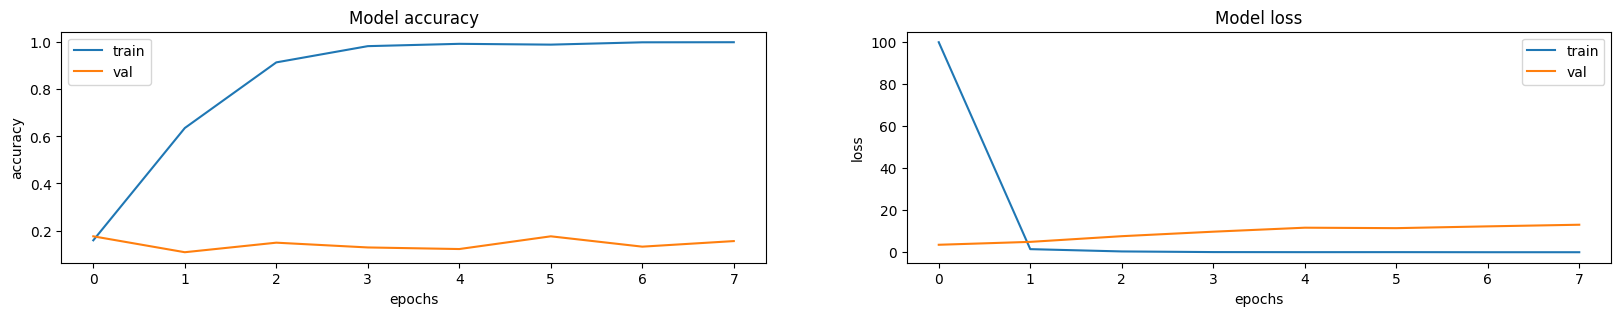

In [19]:
plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1) 
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

test_loss, test_metric = model.evaluate(X_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

In [20]:
pred = model.predict(X_test)
print("Test Input Shape: {} Test output shape: {}".format(X_test.shape, pred.shape))

78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 308ms/step
Test Input Shape: (2485, 256, 256, 3) Test output shape: (2485, 43)


In [21]:
pred = np.argmax(pred, axis = -1)
print(pred)

[13  0 13 ... 13 19 20]


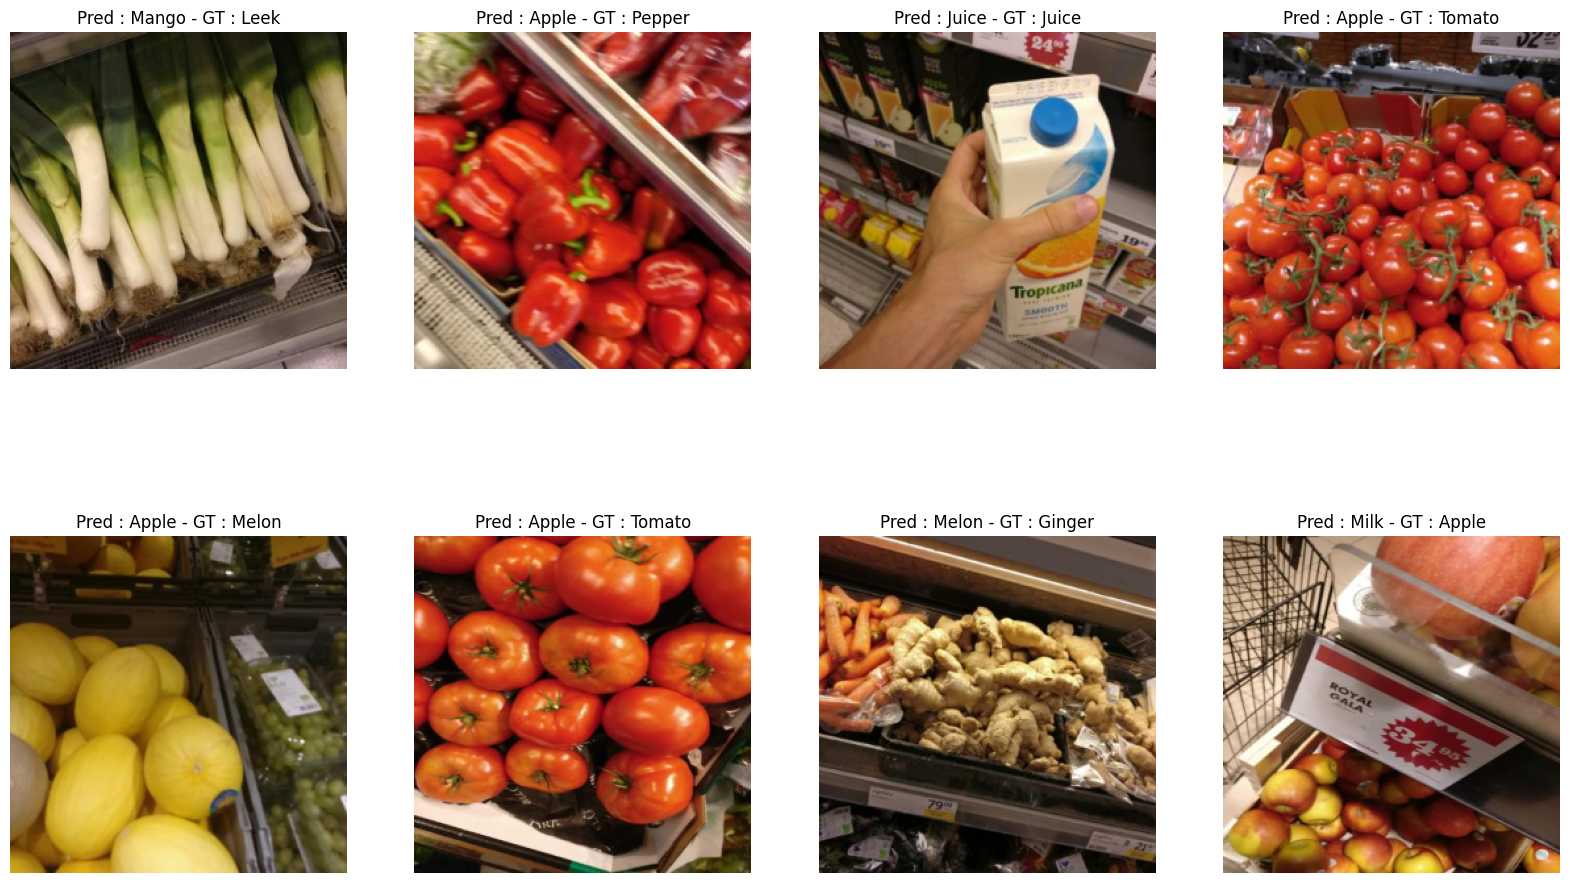

In [24]:
plt.figure(figsize=(20,12))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    rand_idx = np.random.randint(0, X_test.shape[0])
    plt.axis('off')
    plt.title(f"Pred : {labels_coarse[pred[rand_idx]]} - GT : {labels_coarse[y_test[rand_idx]]}")
    plt.imshow(cv2.cvtColor(X_test[rand_idx], cv2.COLOR_BGR2RGB))
plt.show()

<div style='text-align: justify; font-family:TimesNewRoman'>
The results obtained by this initial attempt show a very low accuracy on the validation set (~15%), while the training accuracy reached the 100% threshold. The large discrepancy between these accuracy values is an indication of overfitting: the model is memorising the training samples, rather than learning generalised features.</br>Such behaviour can typycally be attributed to either an excessively high model capacity or to an insufficient amount of training data. Given the deliberately simple network architecture adopted in this iteration, the former explanation is unlikely. It is reasionalbe to conclude the limited size and variability of the training dataset are the primary causes of the overfitting.

<h2 style='font-family:TimesNewRoman'>1.2 Second iteration — Data Augmentation</h2>

<div style='text-align: justify; font-family:TimesNewRoman'>
To address the overfitting observed in the baseline model, data augmentation is introduced into the training pipeline. By applying random transofrmations to the input images, the oevrall diversity of the dataset is increased.
First, though, through the `Rescaling layer` provided by Keras, the pictures are normalised so that their values belongs to the interval [0, 1].</br></br>It is worth noting that Keras provides additional built-in layers for data augmentation. However, preliminary experiments using these layers led to underfitting. Unlike handmade augmentation techniques that explicitly increase the size of the training set, Keras augmentation layers apply random transformations to each image on the fly, just before it is fed to the model during training. As a result, the effective dataset size remains unchanged. While this approach guarantees a high degree of variability across epochs, it also makes the learning task more challinging. Since the model is rarely exposed to the exact image twice, convergence can be slower, particularly when the base dataset is relatively small and the model capacity is limited. For this reasons, an alternative augmentation stratefy was used. </br></br>The augmentation employed takes inspiration from the one seen for AelxNet. It aims to increase the size of the dataset and introduce variability, rather than simply applying transformations. Hence, from each picture originally belonging to the dataset:
<ol>
        <li>
            A random crop of 224x224 is selected (herefore after referred to as `base picture`) → +0
        </li>
        <li>
            Centrally zooming `base picture`, obtaining `base zoomed` → +1
        </li>
        <li>
            Flipping of the `base picture`, obtaining `base flipped` → +1
        </li>
        <li>
            Cutout of a patch from `base flipped`, obtaining `base cut` → +1
        </li>
        <li>
            Contrast stretching and colour jittering on `base picture`, obtaining `altered picture` → +1
        </li>
        <li>
            Flipping of `altered picture`, obtaining `altered flipped` → +1
        </li>
        <li>
            Cutout of a patch from `altered flipped`, obtaining `altered cut` → +1
        </li>
</ol>
The size of the training dataset is increased by adding 6 alterations per picture originally present (~2.500). Hence, the resulting dataset is 7 times the original size, reaching ~17.500 pictures.</br></br>A point which sparked some confrontation invovled the order in which colour jittering and contrast stretching.Contrast stretching operates on the intensity distribution of a picture, normalising the contrast between light and dark areas. Colour jittering, on the other hand, introduces perturbations in brightness, contrast, hue and saturation. It makes sense the perturbations are applied after the picture's intensity distribution is normalised or else the contrast stretching procedure may partially undo the random variations introduced by colour jittering.
</div>

In [ ]:
# DEFINITION OF FUNCTIONS USED IN DATA AUGMENTATION PIPELINE

def color_jittering(img, brightness_range=(-60, 60), saturation_range=(-60, 60)):
    rng = np.random.default_rng()
    img_hsv = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2HSV)

    brightness = rng.integers(brightness_range[0], brightness_range[1])
    saturation = rng.integers(saturation_range[0], saturation_range[1])

    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] + saturation, 0, 255)
    img_hsv[:, :, 2] = np.clip(img_hsv[:, :, 2] + brightness, 0, 255)

    img_hsv = img_hsv.astype(np.uint8)

    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

def contrast_stretching(img, linear_contrast=True, gamma_correction=False, gamma_correction_parameter=1.0):
    img_copy = img.copy()
    
    if linear_contrast:
        p_min = np.percentile(img_copy, 5)
        p_max = np.percentile(img_copy, 95)

        img_copy = np.clip((255/(p_max - p_min)) * (img_copy - p_min), 0, 255).astype(np.uint8)

    if gamma_correction:
        img_copy = np.clip(255 * np.power(img_copy/255, gamma_correction_parameter), 0, 255).astype(np.uint8)

    return img_copy

def cutout(img, size=64, color=50):
    rng = np.random.default_rng()
    img_copy = img.copy()

    x = rng.integers(0, img.shape[0] - size)
    y = rng.integers(0, img.shape[1] - size)

    img_copy[x : x + size, y : y + size] = color
    return img_copy

def zoom(img, zoom_center=None, zoom_pixel=35):
    img_copy = img.copy()
    zoom_tot = img.shape[0] // 2 - zoom_pixel
    
    if zoom_center == None:
        cx = img_copy.shape[0] // 2
        cy = img_copy.shape[1] // 2
    else:
        cx = zoom_center[0]
        cy = zoom_center[y]
    
    pts1 = np.float32([(cx - zoom_tot, cy - zoom_tot), (cx + zoom_tot, cy - zoom_tot), (cx + zoom_tot, cy + zoom_tot), (cx - zoom_tot, cy + zoom_tot)])
    pts2 = np.float32([(0, 0), (img_copy.shape[0], 0), (img_copy.shape[0], img_copy.shape[1]), (0, img_copy.shape[1])])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(img_copy, M, (img.shape[0], img.shape[1]))
    
    return dst
    
def size_to_change(img, size):
    if img.shape[0] <= img.shape[1]:
        return (256, int(np.floor(256 / img.shape[0] * img.shape[1])))
    else:
        return (int(np.floor(256 / img.shape[1] * img.shape[0])), 256)

def get_random_crop(img, cropX=224, cropY=224):
    max_x = img.shape[0] - cropX
    max_y = img.shape[1] - cropY

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = img[x: x + cropX, y: y + cropY]
    
    return crop

# DATA LOADING FUNCTION (ALSO TAKES 224X224 CROPS)
def load_data(url_directory, url_file, size=256, crop_dim=224, random_crop=False, central_crop=False, return_original=False):
    X = []
    y = []
    X_original = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, size_to_change(img, size))
            lbl = int(line_split[2].strip())

            if random_crop:
                crop = get_random_crop(img_resized, crop_dim, crop_dim) # is it fine even for val and test?
            elif central_crop: # center crop
                img_center = (img_resized.shape[0] // 2, img_resized.shape[1] // 2)
                crop_dim_half = crop_dim // 2
                crop = img_resized[
                    img_center[0] - crop_dim_half : img_center[0] - crop_dim_half + crop_dim,
                    img_center[1] - crop_dim_half : img_center[1] - crop_dim_half + crop_dim
                    ]
            else:
                crop = img_resized[:crop_dim, :crop_dim]

            X.append(crop)
            y.append(lbl)

            if return_original:
                img_resized_original = img_resized[:size, :size]
                X_original.append(img_resized_original)

    X = np.stack(X, axis=0)
    y = np.array(y)

    if return_original:
        return X, y, np.stack(X_original, axis=0)
    else:
        return X, y

In [ ]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_train, y_train, X_train_original = load_data(url_directory, "train.txt", random_crop=True, return_original=True)
X_val, y_val = load_data(url_directory, "val.txt")
X_test, y_test = load_data(url_directory, "test.txt")

In [ ]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in df_coarse}
n_classes_coarse = len(labels_coarse)
#labels_coarse

In [ ]:
# DATA AUGMENTATION PIPELINE

X_train_augmented = []
y_train_augmented = []
n_crop = 1
rng = np.random.default_rng()

for idx, img in enumerate(X_train_original):
    lbl = y_train[idx]
    #print(f"shape original: {img.shape}")

    img_base = get_random_crop(img)
    X_train_augmented.append(img_base)
    y_train_augmented.append(lbl)
    #print(f"shape base: {img_base.shape}")

    img_base_zoom = zoom(img_base)
    X_train_augmented.append(img_base_zoom)
    y_train_augmented.append(lbl)

    if rng.integers(2) == 0: 
        img_base_flip = cv2.flip(img_base, 1)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)
    else:
        img_base_flip = cv2.flip(img_base, 0)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)

    #img_base_flip_both = cv2.flip(img_base, -1)
    #X_train_augmented.append(img_base_flip_both)
    #y_train_augmented.append(lbl)

    #if rng.integers(2) == 0:
    img_base_cutout = cutout(img_base_flip)
    X_train_augmented.append(img_base_cutout)
    y_train_augmented.append(lbl)

    for j in range(0, n_crop):
        img_new = get_random_crop(img)
        img_new = contrast_stretching(img_new)
        img_new = color_jittering(img_new)
        X_train_augmented.append(img_new)
        y_train_augmented.append(lbl)
        #print(f"shape new: {img_new.shape}")

        if rng.integers(2) == 0:
            img_new_flip = cv2.flip(img_new, 1) # here we are using the same image, maybe we can have different crop, color jittering etc...
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)
        else:
            img_new_flip = cv2.flip(img_new, 0) # same comment as before
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)

        #if rng.integers(2) == 0:
        img_new_cutout = cutout(img_new_flip)
        X_train_augmented.append(img_new_cutout)
        y_train_augmented.append(lbl)

        #img_new_flip_both = cv2.flip(img_new, -1) # same comment as before
        #X_train_augmented.append(img_new_flip_both)
        #y_train_augmented.append(lbl)
    #print("\n\n")

X_train_augmented = np.stack(X_train_augmented, axis=0)
y_train_augmented = np.array(y_train_augmented)
print(X_train_augmented.shape, y_train_augmented.shape)

In [ ]:
# DEBUG FUNCTION TO DISPLAY A FEW SAMPLES FROM THE AUGMENTED DATASET

fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()
for i in range(20):
    rand_idx = np.random.randint(0, X_train_augmented.shape[0])
    ax[i].set_axis_off()
    ax[i].set_title(f"Class {labels_coarse[y_train_augmented[rand_idx]]}")
    ax[i].imshow(cv2.cvtColor(X_train_augmented[rand_idx], cv2.COLOR_BGR2RGB))

In [ ]:
# NEW MODEL (NOW HAS DATA NORMALISATION LAYER)

input_shape = X_train_augmented.shape[1:]

model_augmented = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        Rescaling(1./255),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model_augmented.summary()

In [ ]:
# MODEL TRAINING

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 8
#val_split_percentage = 0.25

model_augmented.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model_augmented.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

<h2 style='font-family:TimesNewRoman'>1.3 Third iteration — Network tweaking</h2>

<div style='text-align: justify; font-family:TimesNewRoman'>
The introduction of data augmentation/normalisation alone has more than doubled the validation accuracy, hitting an average of approximately 34%. The data augmentation pipeline is now coherent and effective, potentially improving performance once the network becomes more sophisticated. An effective strategy would be further pursuing techniques to increase the size of the dataset; however, almost all the commonly used augmentation transformations have already been applied.</br>For this reason, the focus is shifted to tweaking the network itself without excessively increasing its capacity. </br></br>At this stage, the network layers remain overly simplistic and not suited for the product classification task. The current design is directly inspired by a lab session where the resolution of the input pictures was 28x28, gradually downsampled to 7x7 before reaching the FC layer through two 2x2 pooling steps. </br> In the current project, instead, the inputs are of 224x224, meaning the two pooling layers only downsample them to 56x56, which implies an insufficient increase of the receptive field. To address this, the kernel size of the max-pooling layers was doubled (i.e. 4x4), meaning the activation would reach a spatial size of 14x14 before travelling into the final FC layer.</br></br>Since the data loading and augmentation are left unchanged, only the new model architecture and its training follow:
</div>

In [ ]:
# NEW MODEL (NOW HAS DATA INCREASED DOWNSAMPLING)
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Rescaling

input_shape = X_train_augmented.shape[1:]

model_dwsm = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        Rescaling(1./255),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model_dwsm.summary()

In [ ]:
# MODEL TRAINING

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 8
#val_split_percentage = 0.25

model_dwsm.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model_dwsm.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

<div style='text-align: justify; font-family:TimesNewRoman'>
The result shows an increase in validation accuracy of roughtly 10%, reaching the 44% threshold, proving the model has been struggling due to a low receptive field. Following this discovery, the network was adjusted, pushing for even more downsampling, while also increasing the number of channels and introducing additional convolutional layers. The following architectures have been tested:</br></br>
<table>
    <tr>
        <th style='text-align: center;'>Architecture</th>
        <th style='text-align: center;'>Output shape before FC layer (w, h, c)</th>
        <th style='text-align: center;'>Validation Accuracy</th>
    </tr>
    <tr>
        <td style='text-align: center;'> [Conv → Pool(4×4)] ×2 → [Conv → Pool(2×2)] ×2 → FC</td>
        <td style='text-align: center;'>(3, 3, 256)</td>
        <td style='text-align: center;'>51%</td>
    </tr>
    <tr>
        <td style='text-align: center;'>[Conv → Pool(4×4)] ×2 → [Conv → Pool(2×2)] ×1 → FC</td>
        <td style='text-align: center;'>(7, 7, 128)</td>
        <td style='text-align: center;'>46%</td>
    </tr>
    <tr>
        <td style='text-align: center;'>[Conv → Pool(4×4)] ×3 → FC</td>
        <td style='text-align: center;'>(3, 3, 128)</td>
        <td style='text-align: center;'>50%</td>
    </tr>
</table>
</div>